# UNet on Oxford IIIT Pet dataset Segmentation task

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, download=True)

In [3]:
# Standard normalization of images
# The segmentation map originally had labels (1,2,3), so change
# to (0,1,2)
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [4]:
# We resize all images to be of size 128x128
def load_image(datapoint):
  # For the images we use standard bilinear interpolation
  input_image = tf.image.resize(datapoint['image'], (128, 128))

  # The segementation mask should be integer values 
  # so we choose nearest neighbor interpolation
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [5]:
# Extract training and testing images
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
# Batch the images
train_batches = train_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.AUTOTUNE)

test_batches = test_images.batch(BATCH_SIZE)

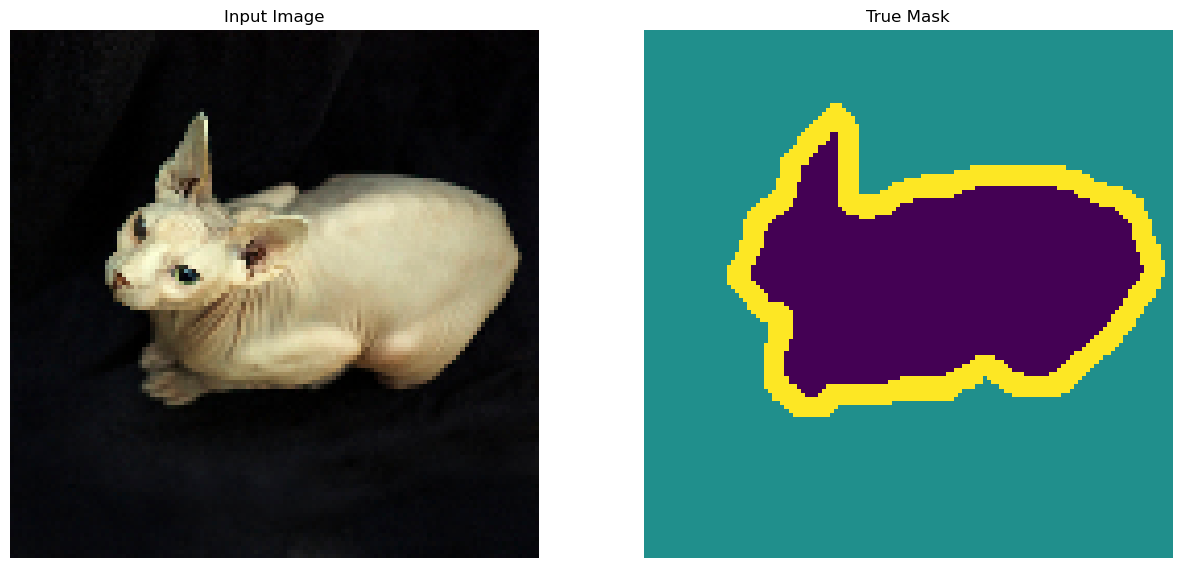

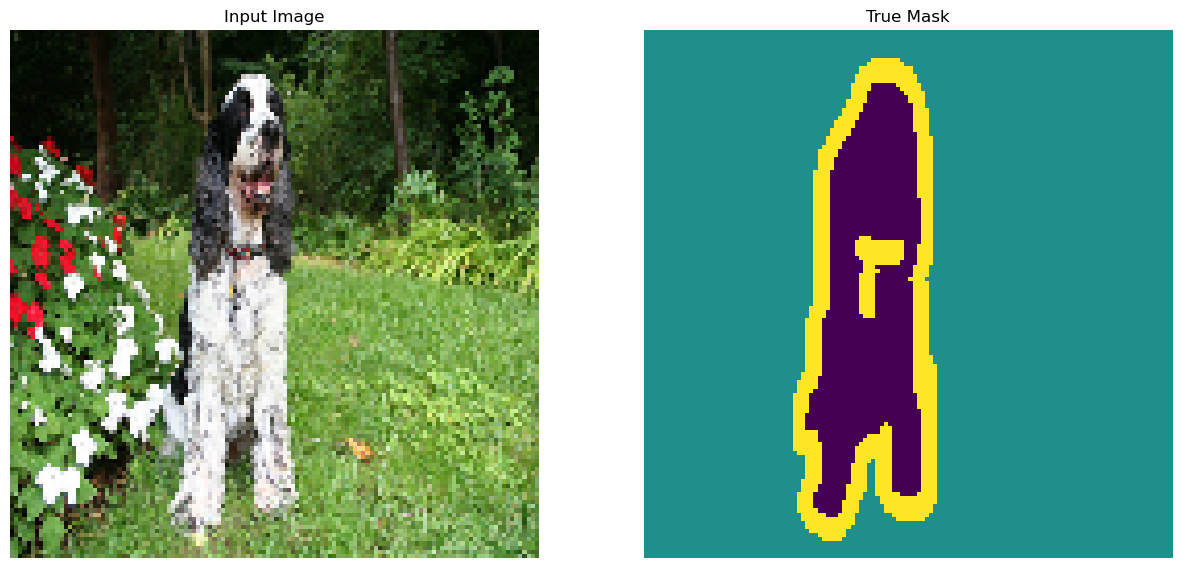

2025-03-17 15:18:04.900126: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# Plot some of the images
for image, mask in train_images.take(2):
  sample_image, sample_mask = image, mask

  fig = plt.figure(figsize=(15, 15))
  plt.subplot(121)
  plt.title('Input Image')
  plt.imshow(tf.keras.utils.array_to_img(sample_image))
  plt.axis('off')
  plt.subplot(122)
  plt.title('True Mask')
  plt.imshow(tf.keras.utils.array_to_img(sample_mask))
  plt.axis('off')
  plt.show()

In [9]:
# This defines a slight variation of the U-net architecture, replacing
# max-pooling with strided convolutions
def unet(input_shape=(128, 128, 3), num_classes=3):

  inputs = tf.keras.layers.Input(input_shape)

  ######### Encoder

  conv1 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
  conv1 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(conv1)
  conv1_strides = tf.keras.layers.Conv2D(16, 3, strides=2, activation='relu', padding='same')(conv1)
  # Output shape: 64x64

  conv2 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv1_strides)
  conv2 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv2)
  conv2_strides = tf.keras.layers.Conv2D(32, 3, strides=2, activation='relu', padding='same')(conv2)
  # Output shape: 32x32

  conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv2_strides)
  conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv3)
  conv3_strides = tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(conv3)
  # Output shape: 16x16

  conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv3_strides)
  conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
  conv4_strides = tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(conv4)
  drop4 = tf.keras.layers.Dropout(0.5)(conv4_strides)
  # Output shape: 8x8

  ######## Bottleneck
  conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(drop4)
  conv5 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
  drop5 = tf.keras.layers.Dropout(0.5)(conv5)
  # Output shape: 8x8

  ######## Decoder

  up6 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(drop5)
  # Output shape: 16x16
  merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
  conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge6)
  conv6 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

  up7 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
  # Output shape: 32x32
  merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
  conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge7)
  conv7 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

  up8 = tf.keras.layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv7)
  # Output shape: 64x64
  merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
  conv8 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(merge8)
  conv8 = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(conv8)

  up9 = tf.keras.layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(conv8)
  # output shape: 128x128
  merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
  conv9 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(merge9)
  conv9 = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(conv9)

  # Output layer
  conv9 = tf.keras.layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(conv9)

  model = tf.keras.Model(inputs=inputs, outputs=conv9)

  return model

# Example usage
model = unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      2,320 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      4,640 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     36,928 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     73,856 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_9[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 128) │    147,584 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 128) │          0 │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 8, 8, 256) │    590,080 │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 256) │          0 │ conv2d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ dropout_1[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,137,603 (8.15 MB)

 Trainable params: 2,137,603 (8.15 MB)

 Non-trainable params: 0 (0.00 B)

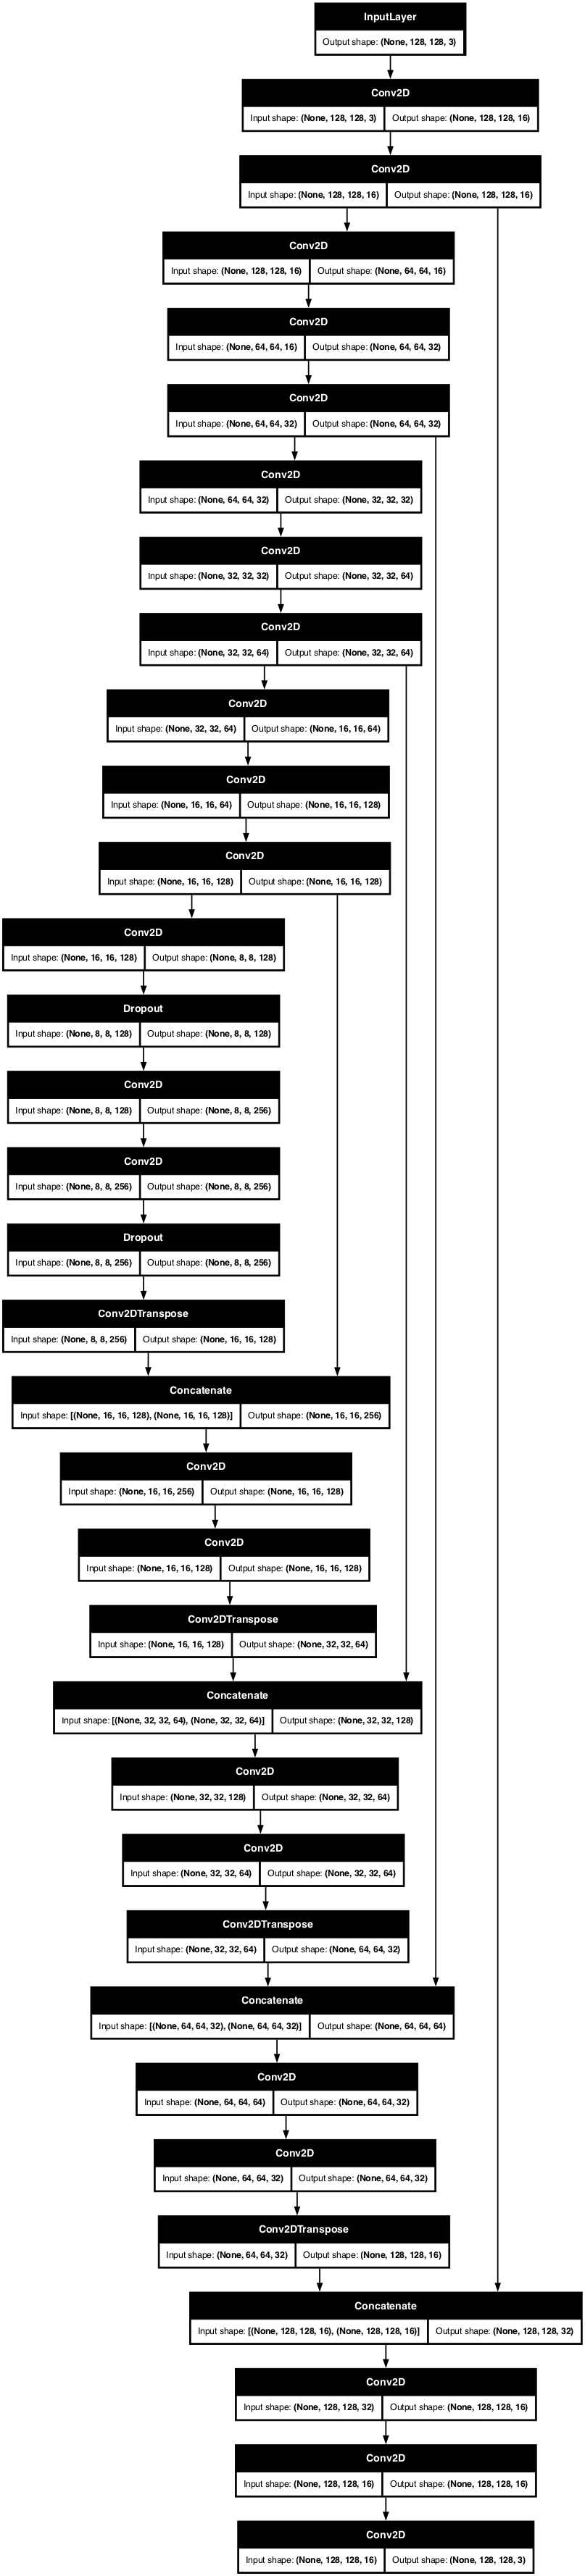

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
# Plotting routine for the model's prediction
def create_mask(predicted_mask):
  mask = tf.math.argmax(predicted_mask, axis=-1)
  mask = mask[..., tf.newaxis]
  return mask[0]

In [16]:
def plot_predictions(dataset, num=1):

  for image, mask in dataset.take(num):
    pred_mask = model.predict(image)

    plt.figure(figsize=(15, 15))
    plt.subplot(131)
    plt.title('Input Image')
    plt.imshow(tf.keras.utils.array_to_img(image[0]))
    plt.axis('off')

    plt.subplot(132)
    plt.title('True Mask')
    plt.imshow(tf.keras.utils.array_to_img(mask[0]))
    plt.axis('off')

    plt.subplot(133)
    plt.title('Predicted Mask')
    plt.imshow(tf.keras.utils.array_to_img(create_mask(pred_mask)))
    plt.axis('off')

    plt.show()

Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2025-03-17 15:41:57.444881: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


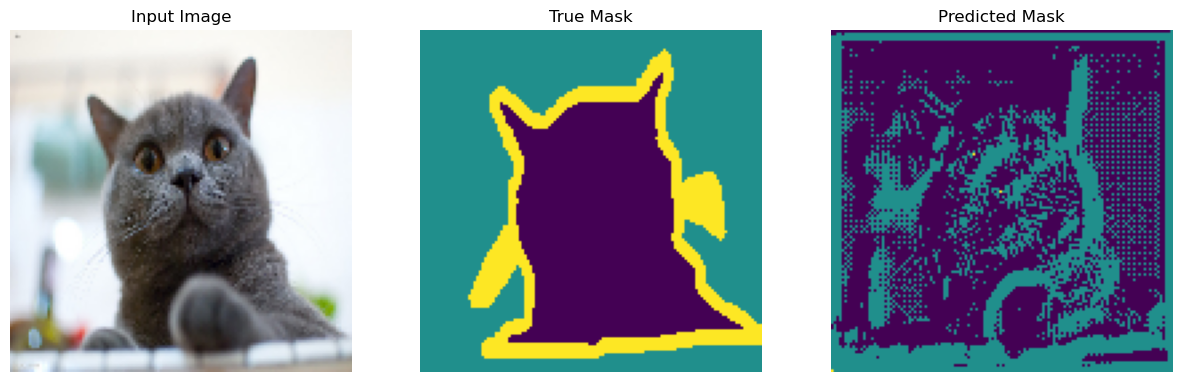

In [18]:
# This is how the results look before training the model
plot_predictions(train_batches, 1)

In [19]:
# Now train the model
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/20


Corrupt JPEG data: 245 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


57/57 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5776 - loss: 0.9785 - val_accuracy: 0.5817 - val_loss: 0.8634
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6665 - loss: 0.7968 - val_accuracy: 0.6919 - val_loss: 0.7600
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7046 - loss: 0.7342 - val_accuracy: 0.7175 - val_loss: 0.6964
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7279 - loss: 0.6743 - val_accuracy: 0.7090 - val_loss: 0.7048
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7223 - loss: 0.6784 - val_accuracy: 0.7436 - val_loss: 0.6299
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.7360 - loss: 0.6406 - val_accuracy: 0.7622 - val_loss: 0.5852
Epoch 7/20


2025-03-17 15:51:21.241026: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Caskroom/miniconda/base/envs/deep12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


57/57 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7544 - loss: 0.6009 - val_accuracy: 0.7627 - val_loss: 0.5861
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7595 - loss: 0.5915 - val_accuracy: 0.7716 - val_loss: 0.5645
Epoch 9/20
52/57 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7732 - loss: 0.5642

KeyboardInterrupt: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


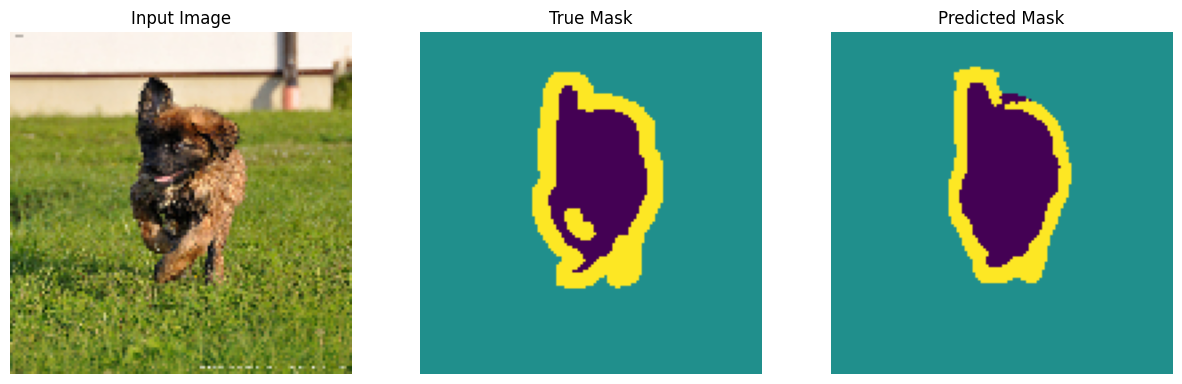

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


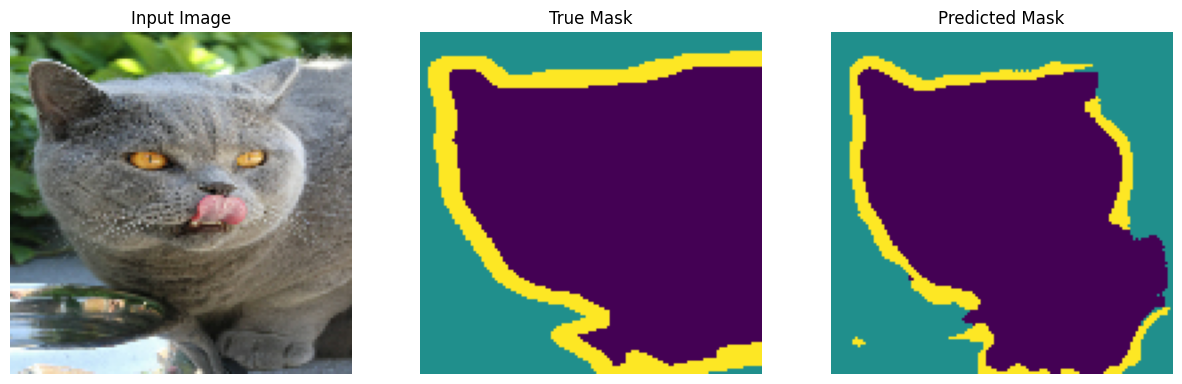

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


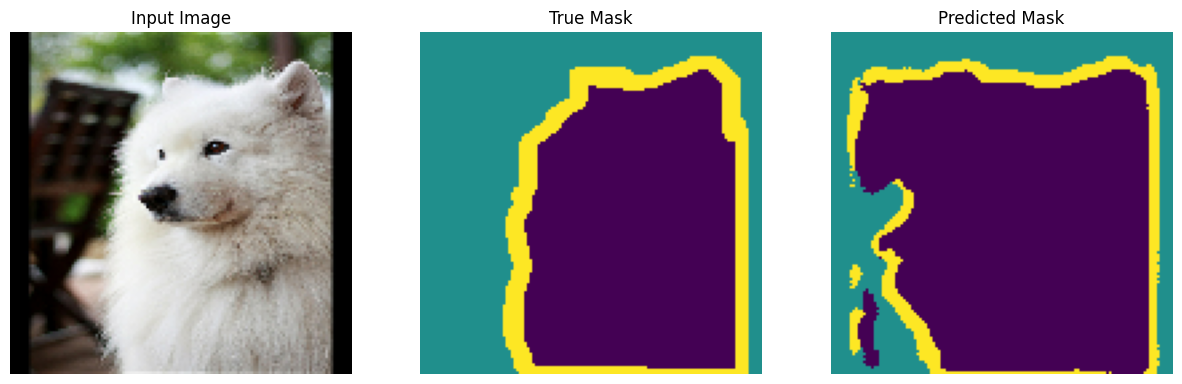

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


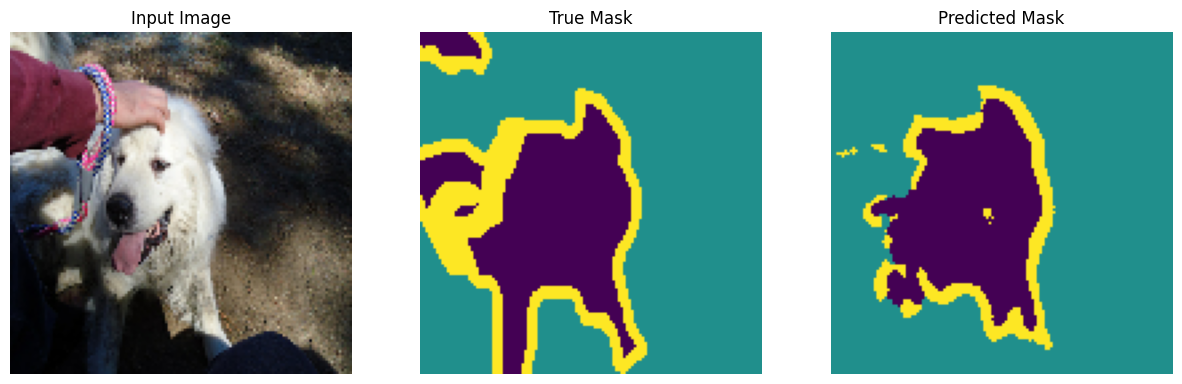

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


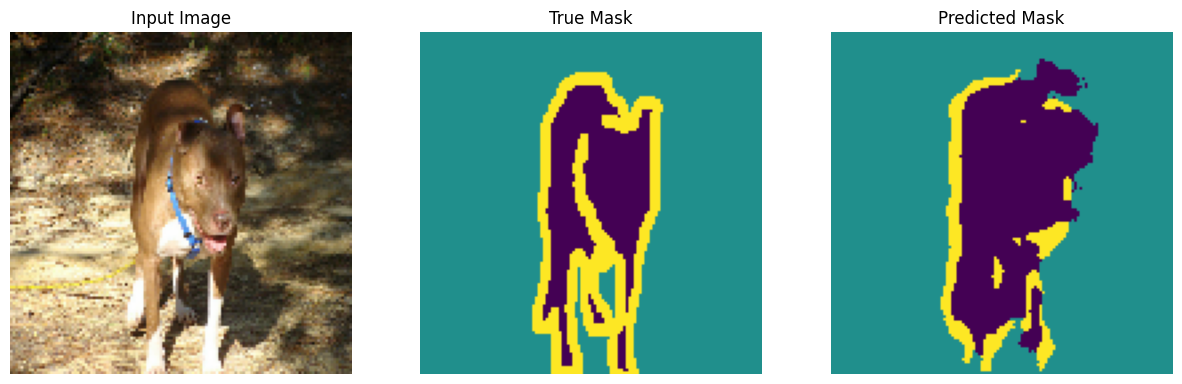

In [35]:
# This is how the results look after training the model
plot_predictions(test_batches, 5)